In [1]:
#library(GEOquery) # just in case
library(data.table)

library(Seurat)
library(dplyr)
library(magrittr)

library(SingleCellExperiment)

library(xlsx)
library(reshape2)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:



In [5]:
regulons<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/TF/male/regulons_indirect.rds")

In [6]:
KO_gene<-read.xlsx("/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_Esr1KOM/Neuron/DEG/gene_adjust_0.1_0.1_246vs34.xlsx",sheetIndex=1)
KO_gene<-as.character(KO_gene[,1])
test<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/TF/male/regulons_indirect.rds")
sum<-numeric()
for(i in 1:length(test)){
    sum<-c(sum,test[[i]])
}
sum<-unique(sum)
TF<-names(regulons)
sum<-unique(c(sum,TF))

In [7]:
length(KO_gene)
length(TF)
length(sum)

[1] 600

[1] 7

[1] 220

In [8]:
sum<-toupper(sum)
KO_gene<-toupper(KO_gene)
Esr1_gene<-toupper(test$Esr1)
TF_gene<-sum[!sum %in% Esr1_gene]
other_gene<-KO_gene[!KO_gene %in% sum]

In [9]:
length(Esr1_gene)
length(TF_gene)
length(other_gene)

[1] 98

[1] 122

[1] 380

In [32]:
# ontology, adjusted p 0.2
Neuron_BP<-read.table(file="/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/TF/male/GO_Biological_Process_2018_table.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Neuron_MF<-read.table(file="/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/TF/male/GO_Molecular_Function_2018_table.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Neuron_CC<-read.table(file="/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_integrated/log/Neurons/TF/male/GO_Cellular_Component_2018_table.txt", header = TRUE, sep = "\t", quote = "\"",dec=".",fill=TRUE,comment.char="")
Neuron_BP<-Neuron_BP[order(Neuron_BP$Adjusted.P.value),]
Neuron_MF<-Neuron_MF[order(Neuron_MF$Adjusted.P.value),]
Neuron_CC<-Neuron_CC[order(Neuron_CC$Adjusted.P.value),]
Neuron_BP<-subset(Neuron_BP,Adjusted.P.value<0.2)
Neuron_MF<-subset(Neuron_MF,Adjusted.P.value<0.2)
Neuron_CC<-subset(Neuron_CC,Adjusted.P.value<0.2)
Neuron_BP$Term<-gsub('.{12}$','',as.character(Neuron_BP$Term))
Neuron_MF$Term<-gsub('.{12}$','',as.character(Neuron_MF$Term))
Neuron_CC$Term<-gsub('.{12}$','',as.character(Neuron_CC$Term))

In [33]:
fraction<-numeric()
for (i in 1:dim(Neuron_CC)[1]){
temp<-eval(parse(text=(as.character(Neuron_CC$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Neuron_CC$fraction<-fraction
neuron_CC_s<-Neuron_CC[1:25,]
neuron_CC_s$Term<-factor(neuron_CC_s$Term,levels=as.character(rev(neuron_CC_s$Term)))

In [34]:
#201129
CC_term<-c("gene_expression","gene_expression","gene_expression","gene_expression","gene_expression",
           "gene_expression","gene_expression","morphology","energy","gene_expression",
           "energy","energy","gene_expression","gene_expression","synapse",
          "gene_expression","morphology","morphology","gene_expression","morphology",           
          "synapse","synapse","gene_expression","gene_expression","synapse",           
          "gene_expression","energy","energy","energy","gene_expression","synapse")

In [35]:
CC_term<-CC_term[1:25]

In [36]:
color<-numeric()
for(i in 1:length(CC_term)){
    if(CC_term[i]=="gene_expression"){color[i]<-"darkgreen"}
    else if(CC_term[i]=="synapse"){color[i]<-"darkblue"}
    else if(CC_term[i]=="energy"){color[i]<-"salmon"}
    else if(CC_term[i]=="morphology"){color[i]<-"yellow3"}
}

In [37]:
# separating fractions into Esr1, TF and others

In [38]:
#Esr1
neuron_CC_Esr1<-neuron_CC_s
neuron_CC_Esr1$type<-"Esr1"
fraction_p<-numeric()
for(i in 1:dim(neuron_CC_Esr1)[1]){
    fraction_p[i]<-neuron_CC_Esr1$fraction[i]*sum(strsplit(as.character(neuron_CC_Esr1[i,"Genes"]),split=";")[[1]] %in% Esr1_gene)/length(strsplit(as.character(neuron_CC_Esr1[i,"Genes"]),split=";")[[1]])
}
neuron_CC_Esr1$fraction_p<-fraction_p
# TF except for Esr1
neuron_CC_TF<-neuron_CC_s
neuron_CC_TF$type<-"TF_gene"

fraction_p<-numeric()
for(i in 1:dim(neuron_CC_TF)[1]){
    fraction_p[i]<-neuron_CC_TF$fraction[i]*sum(strsplit(as.character(neuron_CC_TF[i,"Genes"]),split=";")[[1]] %in% TF_gene)/length(strsplit(as.character(neuron_CC_TF[i,"Genes"]),split=";")[[1]])
}
neuron_CC_TF$fraction_p<-fraction_p
#non Esr1-regulon DEGs
neuron_CC_other<-neuron_CC_s
neuron_CC_other$type<-"other_gene"

fraction_p<-numeric()
for(i in 1:dim(neuron_CC_other)[1]){
    fraction_p[i]<-neuron_CC_other$fraction[i]*sum(strsplit(as.character(neuron_CC_other[i,"Genes"]),split=";")[[1]] %in% other_gene)/length(strsplit(as.character(neuron_CC_other[i,"Genes"]),split=";")[[1]])
}
neuron_CC_other$fraction_p<-fraction_p
neuron_CC_all<-rbind(neuron_CC_Esr1,neuron_CC_TF)
neuron_CC_all<-rbind(neuron_CC_all,neuron_CC_other)
neuron_CC_all$type<-factor(neuron_CC_all$type,levels=c("Esr1","TF_gene","other_gene"))

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


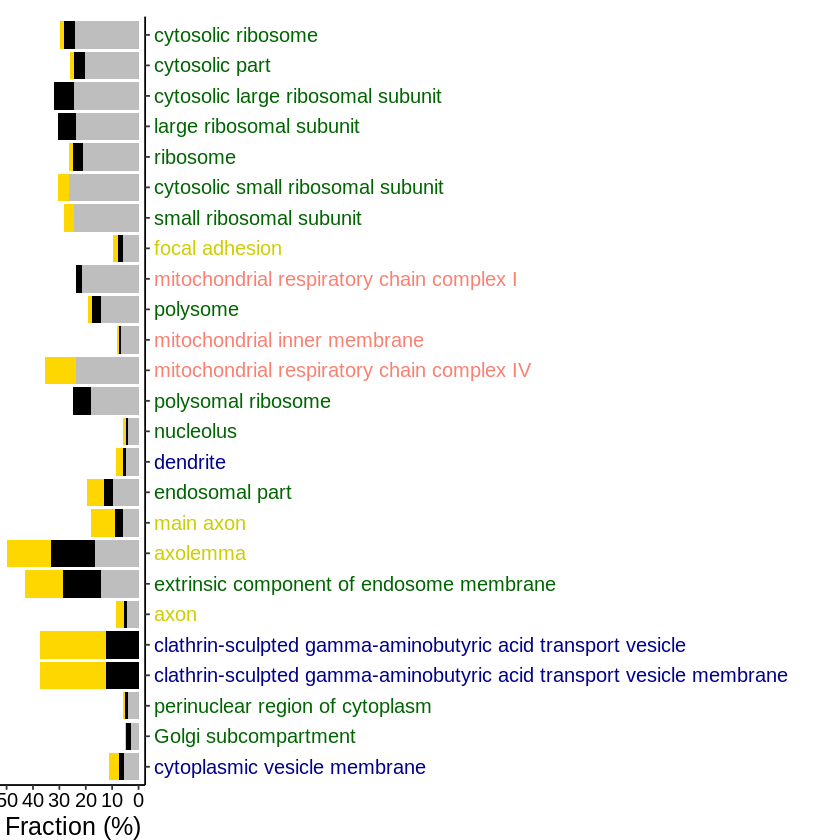

In [39]:
BP<- ggplot(neuron_CC_all, aes(x=Term, y=fraction_p,group=type,fill=type))+geom_bar(stat="identity")+scale_fill_manual(values=c("Esr1"="gold","TF_gene"="black","other_gene"="grey"))+
coord_flip()+ scale_y_reverse(limits=c(50, 0))+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=12,colour=rev(color)),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(),axis.text.x=element_text(size=12,angle = 0, hjust = 0.5,color="black"),axis.title.x=element_text(size=15), axis.line = element_line(colour = "black",size=0.5),axis.ticks.length=unit(.1, "cm"),  axis.ticks.y = element_line(size=0.5) , plot.margin = margin(10, 28, 0, 0))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_Esr1KOM/Neuron/ontologyCC_detailed.pdf",height=4, width=10 , paper = "letter")
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/ontologyCC_detailed_rev#1_com#10.pdf",height=4, width=10 , paper = "letter")

In [19]:
#MF

In [40]:
fraction<-numeric()
for (i in 1:dim(Neuron_MF)[1]){
temp<-eval(parse(text=(as.character(Neuron_MF$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Neuron_MF$fraction<-fraction

neuron_MF_s<-Neuron_MF
neuron_MF_s$Term<-factor(neuron_MF_s$Term,levels=as.character(rev(neuron_MF_s$Term)))

In [41]:
MF_term<-c("gene_expression","energy","energy","morphology","gene_expression",
           "gene_expression","gene_expression","gene_expression","energy","gene_expression","gene_expression")

In [42]:
color<-numeric()
for(i in 1:length(MF_term)){
    if(MF_term[i]=="gene_expression"){color[i]<-"darkgreen"}
    else if(MF_term[i]=="synapse"){color[i]<-"darkblue"}
    else if(MF_term[i]=="energy"){color[i]<-"salmon"}
    else if(MF_term[i]=="morphology"){color[i]<-"yellow3"}
}

In [43]:
#Esr1
neuron_CC_Esr1<-neuron_MF_s
neuron_CC_Esr1$type<-"Esr1"
fraction_p<-numeric()
for(i in 1:dim(neuron_CC_Esr1)[1]){
    fraction_p[i]<-neuron_CC_Esr1$fraction[i]*sum(strsplit(as.character(neuron_CC_Esr1[i,"Genes"]),split=";")[[1]] %in% Esr1_gene)/length(strsplit(as.character(neuron_CC_Esr1[i,"Genes"]),split=";")[[1]])
}
neuron_CC_Esr1$fraction_p<-fraction_p
# TF except for Esr1
neuron_CC_TF<-neuron_MF_s
neuron_CC_TF$type<-"TF_gene"

fraction_p<-numeric()
for(i in 1:dim(neuron_CC_TF)[1]){
    fraction_p[i]<-neuron_CC_TF$fraction[i]*sum(strsplit(as.character(neuron_CC_TF[i,"Genes"]),split=";")[[1]] %in% TF_gene)/length(strsplit(as.character(neuron_CC_TF[i,"Genes"]),split=";")[[1]])
}
neuron_CC_TF$fraction_p<-fraction_p
#non Esr1-regulon DEGs
neuron_CC_other<-neuron_MF_s
neuron_CC_other$type<-"other_gene"

fraction_p<-numeric()
for(i in 1:dim(neuron_CC_other)[1]){
    fraction_p[i]<-neuron_CC_other$fraction[i]*sum(strsplit(as.character(neuron_CC_other[i,"Genes"]),split=";")[[1]] %in% other_gene)/length(strsplit(as.character(neuron_CC_other[i,"Genes"]),split=";")[[1]])
}
neuron_CC_other$fraction_p<-fraction_p
neuron_CC_all<-rbind(neuron_CC_Esr1,neuron_CC_TF)
neuron_CC_all<-rbind(neuron_CC_all,neuron_CC_other)
neuron_CC_all$type<-factor(neuron_CC_all$type,levels=c("Esr1","TF_gene","other_gene"))

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


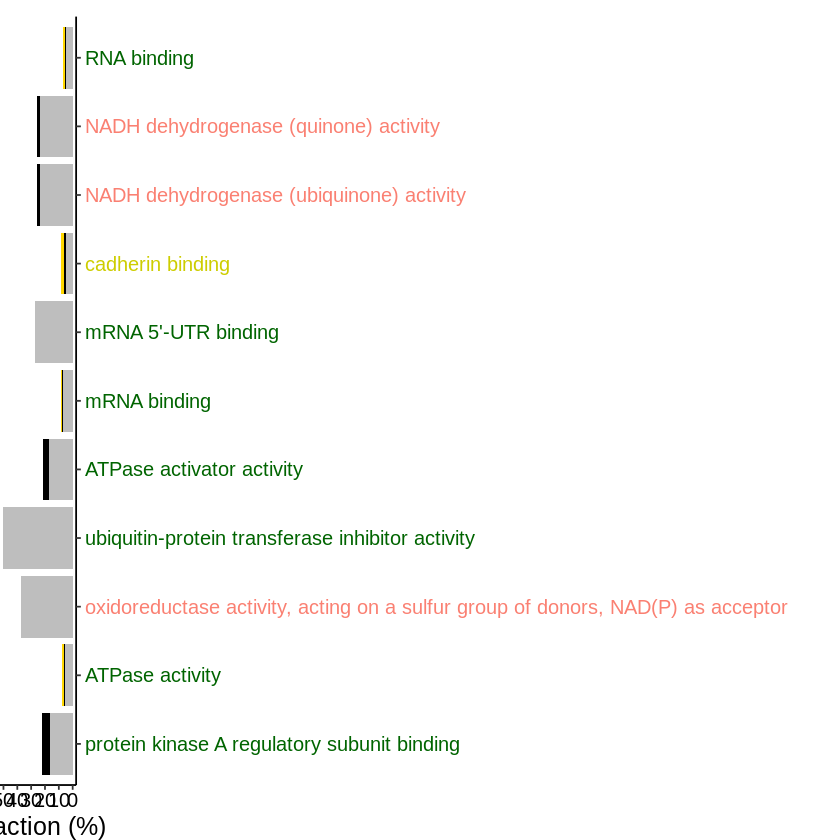

In [44]:
BP<- ggplot(neuron_CC_all, aes(x=Term, y=fraction_p,group=type,fill=type))+geom_bar(stat="identity")+scale_fill_manual(values=c("Esr1"="gold","TF_gene"="black","other_gene"="grey"))+
coord_flip()+ scale_y_reverse(limits=c(50, 0))+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=12,colour=rev(color)),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(),axis.text.x=element_text(size=12,angle = 0, hjust = 0.5,color="black"),axis.title.x=element_text(size=15), axis.line = element_line(colour = "black",size=0.5),axis.ticks.length=unit(.1, "cm"),  axis.ticks.y = element_line(size=0.5) , plot.margin = margin(10, 28, 0, 0))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_Esr1KOM/Neuron/ontologyMF_detailed.pdf",height=4, width=10 , paper = "letter")
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/ontologyMF_detailed_rev#1_com#10.pdf",height=4, width=10 , paper = "letter")

In [ ]:
#BP

In [25]:
fraction<-numeric()
for (i in 1:dim(Neuron_BP)[1]){
temp<-eval(parse(text=(as.character(Neuron_BP$Overlap[i])))) *100
fraction<-c(fraction,temp)
}
Neuron_BP$fraction<-fraction

neuron_BP_s<-Neuron_BP[1:25,]
neuron_BP_s$Term<-factor(neuron_BP_s$Term,levels=as.character(rev(neuron_BP_s$Term)))

In [26]:
BP_term<-c("gene_expression","gene_expression","gene_expression","gene_expression","gene_expression",
           "gene_expression","gene_expression","gene_expression","gene_expression","gene_expression",
           "gene_expression","gene_expression","gene_expression","gene_expression","gene_expression",
           "gene_expression","gene_expression","gene_expression","energy","energy",
           "energy","morphology","energy","morphology","gene_expression",
           "morphology","gene_expression","morphology","gene_expression","gene_expression",
           "energy","energy","energy","morphology","synapse",
           "synapse","energy","gene_expression","gene_expression","synapse",
           "synapse","gene_expression","synapse","gene_expression","synapse",
           "synapse","gene_expression","synapse","synapse","synapse",
           "gene_expression","morphology","gene_expression","energy","gene_expression",
           "gene_expression","gene_expression","gene_expression","energy","gene_expression",
           "energy","gene_expression","gene_expression","gene_expression","gene_expression",
           "gene_expression","gene_expression","gene_expression","synapse","morphology")

In [27]:
BP_term<-BP_term[1:25]

In [28]:
color<-numeric()
for(i in 1:length(BP_term)){
    if(BP_term[i]=="gene_expression"){color[i]<-"darkgreen"}
    else if(BP_term[i]=="synapse"){color[i]<-"darkblue"}
    else if(BP_term[i]=="energy"){color[i]<-"salmon"}
    else if(BP_term[i]=="morphology"){color[i]<-"yellow3"}
}

In [29]:
#Esr1
neuron_CC_Esr1<-neuron_BP_s
neuron_CC_Esr1$type<-"Esr1"
fraction_p<-numeric()
for(i in 1:dim(neuron_CC_Esr1)[1]){
    fraction_p[i]<-neuron_CC_Esr1$fraction[i]*sum(strsplit(as.character(neuron_CC_Esr1[i,"Genes"]),split=";")[[1]] %in% Esr1_gene)/length(strsplit(as.character(neuron_CC_Esr1[i,"Genes"]),split=";")[[1]])
}
neuron_CC_Esr1$fraction_p<-fraction_p
# TF except for Esr1
neuron_CC_TF<-neuron_BP_s
neuron_CC_TF$type<-"TF_gene"

fraction_p<-numeric()
for(i in 1:dim(neuron_CC_TF)[1]){
    fraction_p[i]<-neuron_CC_TF$fraction[i]*sum(strsplit(as.character(neuron_CC_TF[i,"Genes"]),split=";")[[1]] %in% TF_gene)/length(strsplit(as.character(neuron_CC_TF[i,"Genes"]),split=";")[[1]])
}
neuron_CC_TF$fraction_p<-fraction_p
#non Esr1-regulon DEGs
neuron_CC_other<-neuron_BP_s
neuron_CC_other$type<-"other_gene"

fraction_p<-numeric()
for(i in 1:dim(neuron_CC_other)[1]){
    fraction_p[i]<-neuron_CC_other$fraction[i]*sum(strsplit(as.character(neuron_CC_other[i,"Genes"]),split=";")[[1]] %in% other_gene)/length(strsplit(as.character(neuron_CC_other[i,"Genes"]),split=";")[[1]])
}
neuron_CC_other$fraction_p<-fraction_p
neuron_CC_all<-rbind(neuron_CC_Esr1,neuron_CC_TF)
neuron_CC_all<-rbind(neuron_CC_all,neuron_CC_other)
neuron_CC_all$type<-factor(neuron_CC_all$type,levels=c("Esr1","TF_gene","other_gene"))


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


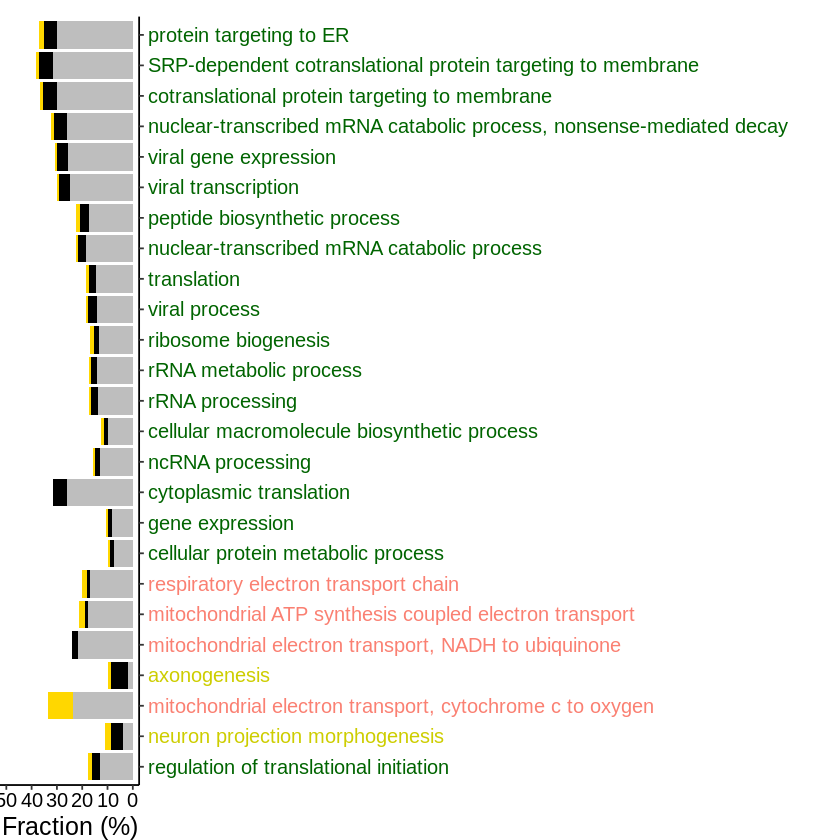

In [31]:
BP<- ggplot(neuron_CC_all, aes(x=Term, y=fraction_p,group=type,fill=type))+geom_bar(stat="identity")+scale_fill_manual(values=c("Esr1"="gold","TF_gene"="black","other_gene"="grey"))+
coord_flip()+ scale_y_reverse(limits=c(50, 0))+scale_x_discrete(position = "top") 
BP+theme(axis.title.y=element_blank(),
        ,axis.text.y=element_text(size=12,colour=rev(color)),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),legend.position = "none",
panel.background = element_blank(),axis.text.x=element_text(size=12,angle = 0, hjust = 0.5,color="black"),axis.title.x=element_text(size=15), axis.line = element_line(colour = "black",size=0.5),axis.ticks.length=unit(.1, "cm"),  axis.ticks.y = element_line(size=0.5) , plot.margin = margin(10, 28, 0, 0))+ylab("Fraction (%)")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Koichi/V3_analysis/MPOA/MPOA_Esr1KOM/Neuron/ontologyBP_detailed.pdf",height=4, width=10 , paper = "letter")
ggsave(file="/media/garret/New Volume/paper submission/MPOA_Science/Revision_Figures/raw/ontologyBP_detailed_rev#1_com#10.pdf",height=4, width=10 , paper = "letter")